In [1]:
# Python Notebook for PHYS 422 Assignment #5

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from matplotlib import rc
import scipy as sp

# extra stuff to make the plots look nice:

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["cmr10"],
          "font.size": 20
         }
plt.rcParams.update(params)
plt.rcParams['axes.formatter.use_mathtext'] = True

import os
os.environ["PATH"]
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Set tick parameters using rcParams
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['xtick.minor.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['ytick.minor.width'] = 0.7

plt.rcParams['font.weight'] = 'bold'

from matplotlib.colors import PowerNorm


### COMPUTATION: 
Here you will explore the radiation pattern from two oscillating electric charges that are
positioned close to each other. For this you can extend upon code you developed in the last assignment where you determined E and B fields and the Poynting vector, S, of a moving particle.

Here consider two moving point charges, A and B, which have charge $q_A=+q$ and q_B = -q = -q_A$ respectively. 

The charges are driven by some agency to move in the $\hat{z}$ having positions:

$$
\vec{r}_A = -d\hat{x} +\frac{d}{2} sin(\omega t) \hat{z}
$$

and:

$$
\vec{r}_B = -\frac{d}{2} sin(2\omega t) \hat{x} -\frac{d}{2} \hat{z}
$$

Determine the E and B fields at points on the boundary of circles that lie in the x-y, y-z and x-z planes, where the circles have radii $R=100 \lambda$ that are centred on the origin, and $\lambda$ is the wavelength of the
radiation emitted. Then, using a method of your choosing, present the Poynting Vector on these circles at
times t = 0, T/4, T/2, 3T/4, where $T=2\pi/\omega$ . Also, determine and plot the time averaged power densityover these circles or using other multiple ‘3D-plots’ if you so wish, to help you explore the radiation pattern
produced. Use f = 600 MHz (where $\omega = 2\pi f$ ), $q = 10^{-9} C$, and $d = 0.07 m$.

### We start where we were with assignment 4:

For this first charge we have that:

$$
\vec{r}_A(t) = -d\hat{x} +\frac{d}{2} sin(\omega t) \hat{z}
$$

$$
\vec{v}_A(t) = 0\hat{x} +\frac{d}{2} \omega cos(\omega t) \hat{z}
$$

$$
\vec{a}_A(t) = 0\hat{x} -\frac{d}{2} \omega^2 sin(\omega t) \hat{z}
$$

And for the second charge we have that:

$$
\vec{r}_B(t) = -\frac{d}{2} sin(2\omega t) \hat{x} -\frac{d}{2} \hat{z}
$$

$$
\vec{v}_B(t) = -d\omega cos(2\omega t) \hat{x} +0\hat{z}
$$

$$
\vec{a}_B(t) = 2d \omega^2 sin(2\omega t) \hat{x} +0\hat{z}
$$

We will follow the same algorithm outlined in assignment 4 with the methodology as follows:

The fields from a moving point charge can be found from the result given in Griffith's such that:

$$
\vec{E}(\vec{r}, t) = \frac{q}{4\pi \epsilon_0} \frac{\mathscr{r} }{(\vec{\mathscr{r} } \cdot \vec{v})^3} [(c^2-v^2)\vec{u} +\vec{\mathscr{r} } \times (\vec{u} \times \vec{a})]
$$

And the magnetic field as:

$$
\vec{B}(\vec{r},t) = \frac{1}{c} \hat{\mathscr{r} } \times \vec{E}(\vec{r}, t)
$$

All quantities in both of the above expressions are evaluated at a retarded time. We may get this time by using the form given in the notes, where $t_r $ is the delayed time for the communication of the movement of the charge such that:

$$
t_r -t + \frac{1}{c}|\vec{r} - \vec{w}(t_r)| = 0
$$

The crux of this problem is finding this time so we may evaluate the functions at it, thus giving our field. To best do this, we rely on root-finding. So we need a form for $\vec{\mathscr{r}}$ which is conveniently:

$$
\vec{\mathscr{r}} = \vec{r} - \vec{w}(t_r)
$$

Similarly, we may find a form for $\vec{u}$ as:

$$
\vec{u} = c \hat{\mathscr{r}} - \vec{v}
$$

We now have almost everything we need, the algorithm we will then take here is:

1. Plug in our actual forms of the position, acceleration and velocity into the above equations.
2. Generate functions that will calcualte the E and B fields for the system given a retarded time, which will come from a time in the evolution of the particle using a root solving method on the above equation. 
3. Evaluate the functions for a given time over a circle of radius $100\lambda$


In [326]:
# we will begin our programming by defining any requisite constants
# and parameters:

# constants:
c      = 3 * 10**8     # m/s
d      = 0.07          # m
q      = 10**(-9)      # C
qa     = q             # C
qb     = -q            # C
ff     = 600 * 10**6   # Hz

e0 = 8.854e-12         # permittivity
mu0 = 1.257e-6         # permeability

# derived constants:
lamb   = c*(1/ff)      # m
w      = 2*np.pi*ff    # rads/s
R      = 100 * lamb    # m
T      = 2*np.pi/omega # s
T_vals = np.array([0, T/4, T/2, 3*T/4, T])/2  # s



In [265]:
# first step is easy, we need to create functions that
# define the motion of each of the particles:

def r_a(t, d=d):
    '''
    takes time t and length d
    and returns the path of
    particle a for those values
    '''
    
    r_x = -d
    r_y = 0
    r_z = (d/2)*np.sin(w*t)
    
    return np.array([r_x,r_y, r_z])

def v_a(t, d=d):
    '''
    takes time t and length d
    and returns the velocity of 
    particle a for those values
    '''
    
    v_x = 0
    v_y = 0
    v_z = (d/2)*w*np.cos(w*t)
    
    return np.array([v_x, v_y, v_x])

def a_a(t, d=d):
    '''
    takes time t and length d
    and returns the acceleration of 
    particle a for those values
    '''
    
    a_x = 0
    a_y = 0
    a_z = -(d/2)*w*w*np.sin(w*t)
    
    return np.array([a_x,a_y,a_z])

def r_b(t, d=d):
    '''
    takes time t and length d
    and returns the path of
    particle b for those values
    '''
    
    r_x = -(d/2)*np.sin(2*w*t)
    r_y = 0
    r_z = -(d/2)
    
    return np.array([r_x,r_y, r_z])

def v_b(t, d=d):
    '''
    takes time t and length d
    and returns the velocity of 
    particle b for those values
    '''
    
    v_x = -(d)*w*np.cos(2*w*t)
    v_y = 0
    v_z = 0
    
    return np.array([v_x, v_y, v_x])

def a_b(t, d=d):
    '''
    takes time t and length d
    and returns the acceleration of 
    particle a for those values
    '''
    
    a_x = 2*(d)*w*w*np.sin(2*w*t)
    a_y = 0
    a_z = 0
    
    return np.array([a_x,a_y,a_z])

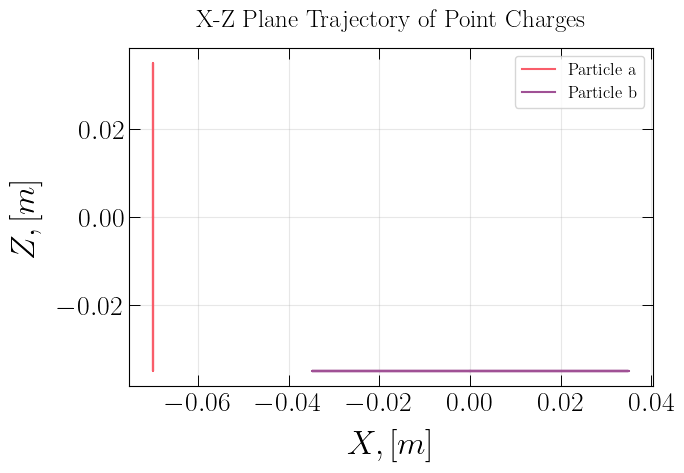

In [266]:
# we can plot the trajectories as a sanity check:
tt = np.linspace(0, 2*T,100)

r_a_x = [r_a(tt[i])[0] for i in range(len(tt))]
r_a_z = [r_a(tt[i])[2] for i in range(len(tt))]

r_b_x = [r_b(tt[i])[0] for i in range(len(tt))]
r_b_z = [r_b(tt[i])[2] for i in range(len(tt))]

# initiates plotting parameters
width=8;height=6;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=4.0)

# labels
ax1.set_title(r"X-Z Plane Trajectory of Point Charges", pad = 15, fontsize=18)
ax1.set_xlabel(r"$X, [m]$",labelpad =10, fontsize=24)
ax1.set_ylabel(r"$Z, [m]$",labelpad =10,fontsize=24)

# actual plots:
ax1.plot(r_a_x, r_a_z,c='#f95d6a' , label=r'Particle a')
ax1.plot(r_b_x, r_b_z,c='#a05195', label=r'Particle b')


# ticks and legend:
#ax1.yaxis.set_major_locator(MultipleLocator(20));ax1.yaxis.set_minor_locator(MultipleLocator(4))
#ax1.xaxis.set_major_locator(MultipleLocator(1000));ax1.xaxis.set_minor_locator(MultipleLocator(200))
ax1.tick_params(axis='both', direction="in")
ax1.tick_params(which="minor", axis="x", direction="in")
ax1.tick_params(which="minor", axis="y", direction="in")
ax1.xaxis.set_ticks_position('both') 
ax1.yaxis.set_ticks_position('both')
ax1.grid(True, alpha=0.3, zorder=10)

ax1.legend(fontsize=12)
plt.show()

Alrighty I guess that makes sense from the trajectories since 
there is not time dependence on one of the two coordinates.

We now need an explicit form of the retarded time as in the last assignment for both of the trajectories:

For particle A:

$$
t_r - t +\frac{1}{c} |\vec{r} +d\hat{x} -\frac{d}{2}sin(\omega t_r) \hat{z}| = 0
$$

$$
t_r - t +\frac{1}{c} \sqrt{(x +d)^2 +(z-\frac{d}{2}sin(\omega t_r) )^2} = 0
$$

For particle B:

$$
t_r - t +\frac{1}{c} |\vec{r} +\frac{d}{2}sin(2\omega t_r)\hat{x} +\frac{d}{2}\hat{z}| = 0
$$

$$
t_r - t +\frac{1}{c} \sqrt{(x +\frac{d}{2}sin(2\omega t_r))^2 +(z+\frac{d}{2}\hat{z} )^2} = 0
$$

In [267]:
# we can then define functions for the retarded time:

def ret_a(t_r, T, X, Y, Z):
    '''
    takes an input retarded time,
    present time, t, and a coordinate 
    and returns the function
    that must be root solved
    for particle a
    '''
    
    r_mag = np.sqrt((X+d)**2 + (Z-(d/2)* np.sin(w*t_r))**2)
    
    root_func = t_r - T + r_mag/c
    
    return root_func

def ret_b(t_r, T, X, Y, Z):
    '''
    takes an input retarded time,
    present time, t, and a coordinate 
    and returns the function
    that must be root solved
    for particle b
    '''
    
    r_mag = np.sqrt((X+(d/2)*np.sin(2*w*t_r))**2 + (Z+d/2)**2)
    
    root_func = t_r - T + r_mag/c
    
    return root_func

# now we can define our E and B field:

def electric_field(a_or_b, t_r, r):
    '''
    Takes a particle label,
    position vector r
    and a retarded time t_r 
    and returns the E field
    '''
    if a_or_b =='A':
        position     = r_a
        velocity     = v_a
        acceleration = a_a
    elif a_or_b == 'B':
        position     = r_b
        velocity     = v_b
        acceleration = a_b
        
    # prefactor:
    prefactor = q/(4*np.pi * e0)
    # need the seperation vector:
    sep_vec = r - position(t_r)
    sep_mag = np.sqrt(sep_vec[0]**2 + sep_vec[1]**2 + sep_vec[2]**2)
    # and the unit vector:
    sep_unit = sep_vec/sep_mag
    
    # need the acceleration and u vectors:
    accel = acceleration(t_r)
    u_vec = c*sep_mag - velocity(t_r)
    vel_mag = np.sqrt(velocity(t_r)[0]**2-velocity(t_r)[1]**2 + velocity(t_r)[2]**2)
    
    # can now do the cross product as outlined earlier:
    double_cross = np.cross(sep_vec, np.cross(u_vec, accel))
    
    # and only take the x, y components:
    xy_cross = double_cross
    
    # denominator:
    denom = (np.dot(sep_vec, u_vec))**3
    
    # finally the field:
    E_field = prefactor* (sep_mag/denom ) * ((c**2 - vel_mag**2)*u_vec + xy_cross)
    
    return E_field

def magnetic_field(a_or_b, t_r, r):
    '''
    Takes a particle label,
    position vector r
    and a retarded time t_r 
    and returns the B field
    '''
    if a_or_b =='A':
        position     = r_a
        velocity     = v_a
        acceleration = a_a
    elif a_or_b == 'B':
        position     = r_b
        velocity     = v_b
        acceleration = a_b
        
    # need the seperation vector:
    sep_vec = r - position(t_r)
    sep_mag = np.sqrt(sep_vec[0]**2 + sep_vec[1]**2+sep_vec[2]**2)
    # and the unit vector:
    sep_unit = sep_vec/sep_mag

    E_field = electro_field(a_or_b, t_r, r)
    
    B_field = (1/c)*np.cross(sep_unit, E_field)
    
    return B_field


In [268]:
# now the above fields are for individual particles
# the fields will add linearly and so we can write functions
# that return the entire field:

def e_total(t_ra, t_rb, r):
    '''
    takes a position vector r
    and a retarded time t_r
    for both particles
    and returns the total
    E field
    '''
    whole_field = np.array(electric_field('A', t_r_a, r)) + \
                    np.array(electric_field('B', t_r_b, r))
    
    return whole_field

def b_total(t_ra, t_rb, r):
    '''
    takes a position vector r
    and a retarded time t_r 
    for both particles
    and returns the total
    B field
    '''
    whole_field = np.array(magnetic_field('A', t_r_a, r)) + \
                    np.array(magnetic_field('B', t_r_b, r))
    
    return whole_field

# we can make vectorized versions of the fields such that they 
# are easier to evaluate:

e_field = np.vectorize(e_total, excluded=['t_r_a', 't_r_b'])
b_field = np.vectorize(b_total, excluded=['t_r_a', 't_r_b'])

The coordinates of a circle can be decomposed according to an angle parameter as follows. We will use the X-Y plane as an example:

$$
X(x-y \ plane) = R cos(\theta)
$$

$$
Y(x-y \ plane) = R sin(\theta)
$$

$$
Z(x-y \ plane) = 0
$$

In [269]:
# we can now calculate the E and B fields for all values in the cirle
# with radius 100lambda, but first need to define the circles:

radians = np.linspace(0, 2*np.pi, 100)

# circle in the X-Y plane:

x_xy = R * np.cos(radians)
y_xy = R * np.sin(radians)
z_xy = np.zeros(len(radians))

# circle in the X-Z plane:

x_xz = R * np.sin(radians)
y_xz = np.zeros(len(radians))
z_xz = R * np.cos(radians)

# cirle in the Y-Z plane:

x_yz = np.zeros(len(radians))
y_yz = R * np.cos(radians)
z_yz = R * np.sin(radians)

In [270]:
# now we can calculate the fields: lets do it for T/2 

test = T/2

e_field_xy = [np.array([0,0,0]) for i in range(len(x_xy))]

for i in range(len(x_xy)):
    t_r_a = sp.optimize.root(ret_a, 0, args=(test, x_xy[i], y_xy[i], z_xy[i])).x[0]
    t_r_b = sp.optimize.root(ret_b, 0, args=(test, x_xy[i], y_xy[i], z_xy[i])).x[0]
    e_i = e_total(t_r_a, t_r_b, np.array([x_xy[i], y_xy[i], z_xy[i]]))
    e_field_xy[i] = e_i #/np.linalg.norm(e_i)
    
e_field_xz = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    t_r_a = sp.optimize.root(ret_a, 0, args=(test, x_xz[i], y_xz[i], z_xz[i])).x[0]
    t_r_b = sp.optimize.root(ret_b, 0, args=(test, x_xz[i], y_xz[i], z_xz[i])).x[0]
    e_i = e_total(t_r_a, t_r_b, np.array([x_xz[i], y_xz[i], z_xz[i]]))
    e_field_xz[i] = e_i #/np.linalg.norm(e_i)

e_field_yz = [np.array([0,0,0]) for i in range(len(x_yz))]

for i in range(len(x_yz)):
    t_r_a = sp.optimize.root(ret_a, 0, args=(test, x_yz[i], y_yz[i], z_yz[i])).x[0]
    t_r_b = sp.optimize.root(ret_b, 0, args=(test, x_yz[i], y_yz[i], z_yz[i])).x[0]
    e_i = e_total(t_r_a, t_r_b, np.array([x_yz[i], y_yz[i], z_yz[i]]))
    e_field_yz[i] = e_i #/np.linalg.norm(e_i)
    
b_field_xy = [np.array([0,0,0]) for i in range(len(x_xy))]

for i in range(len(x_xy)):
    t_r_a = sp.optimize.root(ret_a, 0, args=(test, x_xy[i], y_xy[i], z_xy[i])).x[0]
    t_r_b = sp.optimize.root(ret_b, 0, args=(test, x_xy[i], y_xy[i], z_xy[i])).x[0]
    b_i = b_total(t_r_a, t_r_b, np.array([x_xy[i], y_xy[i], z_xy[i]]))
    b_field_xy[i] = b_i #/np.linalg.norm(b_i)
    
b_field_xz = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    t_r_a = sp.optimize.root(ret_a, 0, args=(test, x_xz[i], y_xz[i], z_xz[i])).x[0]
    t_r_b = sp.optimize.root(ret_b, 0, args=(test, x_xz[i], y_xz[i], z_xz[i])).x[0]
    b_i = b_total(t_r_a, t_r_b, np.array([x_xz[i], y_xz[i], z_xz[i]]))
    b_field_xz[i] = b_i #/np.linalg.norm(b_i)

b_field_yz = [np.array([0,0,0]) for i in range(len(x_yz))]

for i in range(len(x_yz)):
    t_r_a = sp.optimize.root(ret_a, 0, args=(test, x_yz[i], y_yz[i], z_yz[i])).x[0]
    t_r_b = sp.optimize.root(ret_b, 0, args=(test, x_yz[i], y_yz[i], z_yz[i])).x[0]
    b_i = b_total(t_r_a, t_r_b, np.array([x_yz[i], y_yz[i], z_yz[i]]))
    b_field_yz[i] = b_i #/np.linalg.norm(b_i)
    

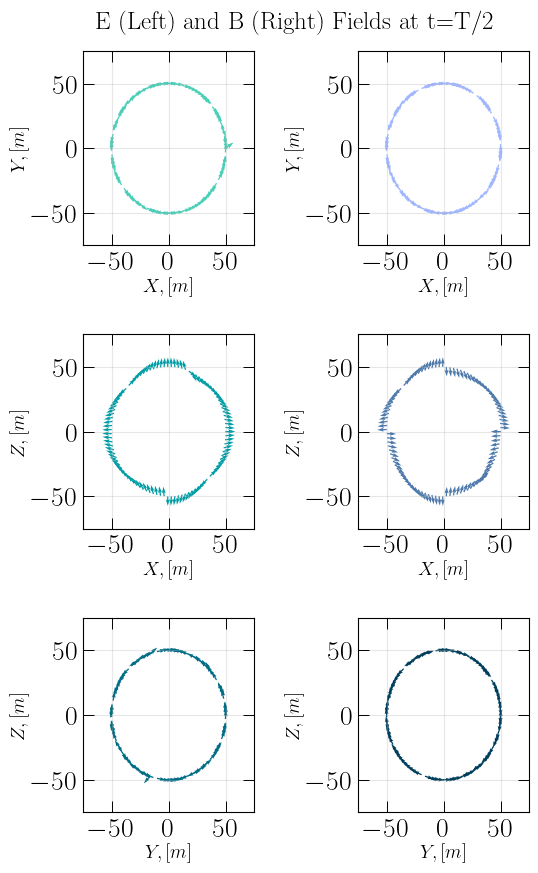

In [271]:
# initiates plotting parameters
width=6;height=9;ff, ax1 = plt.subplots(3,2);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=1.8)

# labels
ff.suptitle(r"E (Left) and B (Right) Fields at t=T/2", fontsize=18)
ax1[0,0].set_xlabel(r"$X, [m]$",labelpad =1.5, fontsize=14)
ax1[0,0].set_ylabel(r"$Y, [m]$",labelpad =1.5,fontsize=14)
ax1[1,0].set_xlabel(r"$X, [m]$",labelpad =1.5, fontsize=14)
ax1[1,0].set_ylabel(r"$Z, [m]$",labelpad =1.5,fontsize=14)
ax1[2,0].set_xlabel(r"$Y, [m]$",labelpad =1.5, fontsize=14)
ax1[2,0].set_ylabel(r"$Z, [m]$",labelpad =1.5,fontsize=14)
ax1[0,1].set_xlabel(r"$X, [m]$",labelpad =1.5, fontsize=14)
ax1[0,1].set_ylabel(r"$Y, [m]$",labelpad =1.5,fontsize=14)
ax1[1,1].set_xlabel(r"$X, [m]$",labelpad =1.5, fontsize=14)
ax1[1,1].set_ylabel(r"$Z, [m]$",labelpad =1.5,fontsize=14)
ax1[2,1].set_xlabel(r"$Y, [m]$",labelpad =1.5, fontsize=14)
ax1[2,1].set_ylabel(r"$Z, [m]$",labelpad =1.5,fontsize=14)

# actual plots:
for i in range(len(x_xz)):
    ax1[0,0].quiver(x_xy[i], y_xy[i], e_field_xy[i][0],e_field_xy[i][1], color='#4acfb8')
for i in range(len(x_xz)):
    ax1[1,0].quiver(x_xy[i], y_xy[i], e_field_xz[i][0],e_field_xz[i][2], color='#009da6')
for i in range(len(x_xz)):
    ax1[2,0].quiver(x_xy[i], y_xy[i], e_field_yz[i][1],e_field_yz[i][2], color='#006d86')
for i in range(len(x_xz)):
    ax1[0,1].quiver(x_xy[i], y_xy[i], b_field_xy[i][0],b_field_xy[i][1], color='#a0b6ff')
for i in range(len(x_xz)):
    ax1[1,1].quiver(x_xy[i], y_xy[i], b_field_xz[i][0],b_field_xz[i][2], color='#4d79ab')
for i in range(len(x_xz)):
    ax1[2,1].quiver(x_xy[i], y_xy[i], b_field_yz[i][1],b_field_yz[i][2], color='#003f5c')


ax1[0,0].xaxis.set_ticks_position('both') 
ax1[0,0].yaxis.set_ticks_position('both')
ax1[0,0].grid(True, alpha=0.3, zorder=10)
ax1[1,0].xaxis.set_ticks_position('both') 
ax1[1,0].yaxis.set_ticks_position('both')
ax1[1,0].grid(True, alpha=0.3, zorder=10)
ax1[2,0].xaxis.set_ticks_position('both') 
ax1[2,0].yaxis.set_ticks_position('both')
ax1[2,0].grid(True, alpha=0.3, zorder=10)
ax1[0,1].xaxis.set_ticks_position('both') 
ax1[0,1].yaxis.set_ticks_position('both')
ax1[0,1].grid(True, alpha=0.3, zorder=10)
ax1[1,1].xaxis.set_ticks_position('both') 
ax1[1,1].yaxis.set_ticks_position('both')
ax1[1,1].grid(True, alpha=0.3, zorder=10)
ax1[2,1].xaxis.set_ticks_position('both') 
ax1[2,1].yaxis.set_ticks_position('both')
ax1[2,1].grid(True, alpha=0.3, zorder=10)

ax1[0,0].set_xlim(-75,75)
ax1[0,0].set_ylim(-75,75)
ax1[1,0].set_xlim(-75,75)
ax1[1,0].set_ylim(-75,75)
ax1[2,0].set_xlim(-75,75)
ax1[2,0].set_ylim(-75,75)
ax1[0,1].set_xlim(-75,75)
ax1[0,1].set_ylim(-75,75)
ax1[1,1].set_xlim(-75,75)
ax1[1,1].set_ylim(-75,75)
ax1[2,1].set_xlim(-75,75)
ax1[2,1].set_ylim(-75,75)

plt.show()

We now wish to calculate the Poynting vector for this configuration.
The Poynting vector is given by:

$$
\vec{S} = \frac{1}{\mu_0} \vec{E} \times \vec{B}
$$

We will now write a function that computes this:



In [272]:
def poynting(t, r):
    '''
    takes a time, t,
    and a position vector r
    and returns the poynting 
    vector at that position
    '''
    x = r[0]; y=r[1]; z=r[2]
    
    # retarded times:
    t_r_a = sp.optimize.root(ret_a, 0, args=(t,x,y,z)).x[0]
    t_r_b = sp.optimize.root(ret_b, 0, args=(t,x,y,z)).x[0]

    # fields:
    e_f = e_total(t_r_a, t_r_b, np.array([x,y,z]))
    b_f = b_total(t_r_a, t_r_b, np.array([x,y,z]))

    # poynting:
    poynting_vec = (1/mu0) * np.cross(e_f, b_f)
    
    return poynting_vec

In [300]:
# we can now calculate the poynting vector for every time and 
# for all three axes. 

# for T=0:

s_xz_0 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[0], np.array([x_xz[i], y_xz[i], z_xz[i]]))
    s_xz_0[i] = s_i /np.linalg.norm(s_i)
    
s_xy_0 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[0], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_xy_0[i] = s_i /np.linalg.norm(s_i)

s_yz_0 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[0], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_yz_0[i] = s_i /np.linalg.norm(s_i)

# for T =T/4:

s_xz_1 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[1], np.array([x_xz[i], y_xz[i], z_xz[i]]))
    s_xz_1[i] = s_i /np.linalg.norm(s_i)
    
s_xy_1 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[1], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_xy_1[i] = s_i /np.linalg.norm(s_i)

s_yz_1 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[1], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_yz_1[i] = s_i /np.linalg.norm(s_i)

# for T=T/2:

s_xz_2 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[2], np.array([x_xz[i], y_xz[i], z_xz[i]]))
    s_xz_2[i] = s_i /np.linalg.norm(s_i)
    
s_xy_2 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[2], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_xy_2[i] = s_i /np.linalg.norm(s_i)

s_yz_2 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[2], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_yz_2[i] = s_i /np.linalg.norm(s_i)
    
# for T=3T/4:

s_xz_3 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[3], np.array([x_xz[i], y_xz[i], z_xz[i]]))
    s_xz_3[i] = s_i /np.linalg.norm(s_i)
    
s_xy_3 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[3], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_xy_3[i] = s_i /np.linalg.norm(s_i)

s_yz_3 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[3], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_yz_3[i] = s_i /np.linalg.norm(s_i)

# for T = T:

s_xz_4 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[4], np.array([x_xz[i], y_xz[i], z_xz[i]]))
    s_xz_4[i] = s_i /np.linalg.norm(s_i)
    
s_xy_4 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[4], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_xy_4[i] = s_i /np.linalg.norm(s_i)

s_yz_4 = [np.array([0,0,0]) for i in range(len(x_xz))]

for i in range(len(x_xz)):
    s_i = poynting(T_vals[4], np.array([x_xy[i], y_xy[i], z_xy[i]]))
    s_yz_4[i] = s_i /np.linalg.norm(s_i)

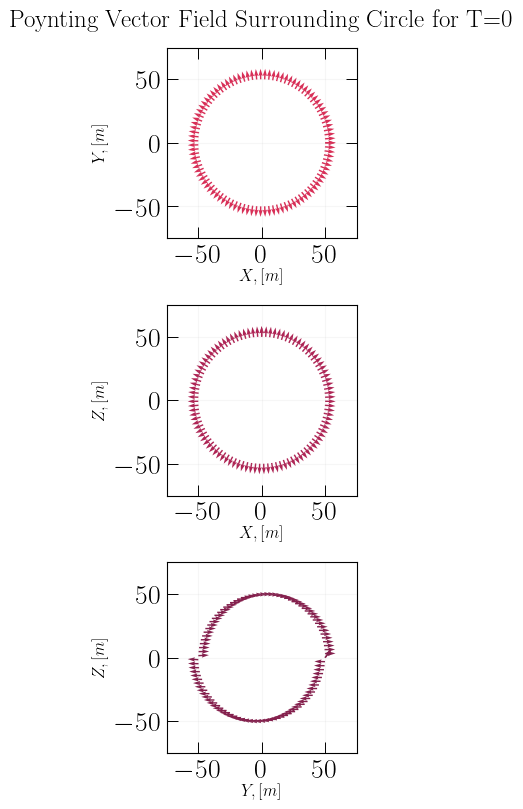

In [324]:
# initiates plotting parameters
width=3;height=8;ff, (ax1,ax2,ax3) = plt.subplots(3,1);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=1.0)

# labels
ax1.set_title(r"Poynting Vector Field Surrounding Circle for T=0", pad = 15, fontsize=18)
ax1.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax1.set_ylabel(r"$Y, [m]$",labelpad =5,fontsize=12)
ax2.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax2.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
ax3.set_xlabel(r"$Y, [m]$",labelpad =0, fontsize=12)
ax3.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
# actual plots:

for i in range(len(x_xz)):
    ax1.quiver(x_xy[i], y_xy[i], s_xy_0[i][0],s_xy_0[i][1], color='#d82f57')

for i in range(len(x_xz)):
    ax2.quiver(x_xz[i], z_xz[i], s_xz_0[i][0],s_xz_0[i][2], color='#ae2555')

for i in range(len(x_xz)):
    ax3.quiver(y_yz[i], z_yz[i], s_yz_0[i][1],s_yz_0[i][2], color='#84204d')

ax1.grid(True, alpha=0.1, zorder=10)
ax2.grid(True, alpha=0.1, zorder=10)
ax3.grid(True, alpha=0.1, zorder=10)
ax1.set_xlim(-75, 75)
ax1.set_ylim(-75, 75)
ax2.set_xlim(-75, 75)
ax2.set_ylim(-75, 75)
ax3.set_xlim(-75, 75)
ax3.set_ylim(-75, 75)

plt.show()
    

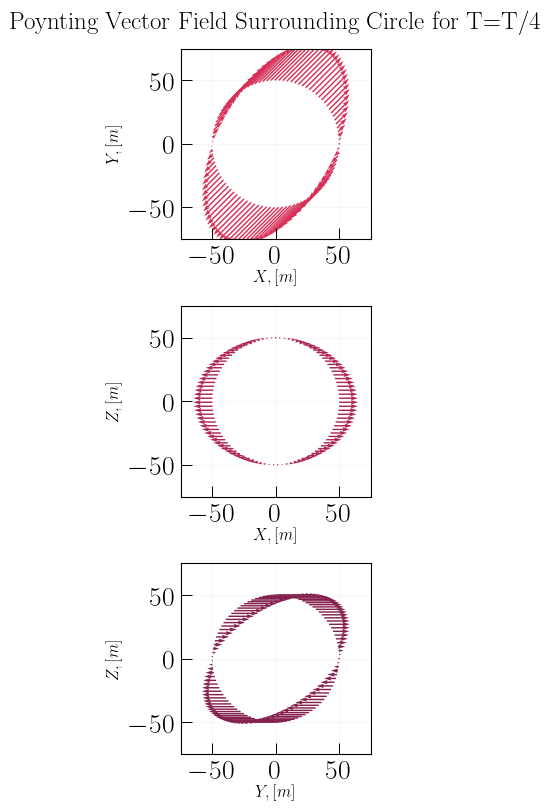

In [372]:
# initiates plotting parameters
width=3;height=8;ff, (ax1,ax2,ax3) = plt.subplots(3,1);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=1.0)

# labels
ax1.set_title(r"Poynting Vector Field Surrounding Circle for T=T/4", pad = 15, fontsize=18)
ax1.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax1.set_ylabel(r"$Y, [m]$",labelpad =5,fontsize=12)
ax2.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax2.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
ax3.set_xlabel(r"$Y, [m]$",labelpad =0, fontsize=12)
ax3.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
# actual plots:

for i in range(len(x_xz)):
    ax1.quiver(x_xy[i], y_xy[i], s_xy_1[i][1],s_xy_1[i][1], color='#d82f57',scale=5)

for i in range(len(x_xz)):
    ax2.quiver(x_xz[i], z_xz[i], s_xz_1[i][0],s_xz_1[i][1], color='#ae2555', scale=10)

for i in range(len(x_xz)):
    ax3.quiver(y_yz[i], z_yz[i], s_yz_1[i][1],s_yz_1[i][2], color='#84204d', scale=5)

ax1.grid(True, alpha=0.1, zorder=10)
ax2.grid(True, alpha=0.1, zorder=10)
ax3.grid(True, alpha=0.1, zorder=10)
ax1.set_xlim(-75, 75)
ax1.set_ylim(-75, 75)
ax2.set_xlim(-75, 75)
ax2.set_ylim(-75, 75)
ax3.set_xlim(-75, 75)
ax3.set_ylim(-75, 75)

plt.show()
    

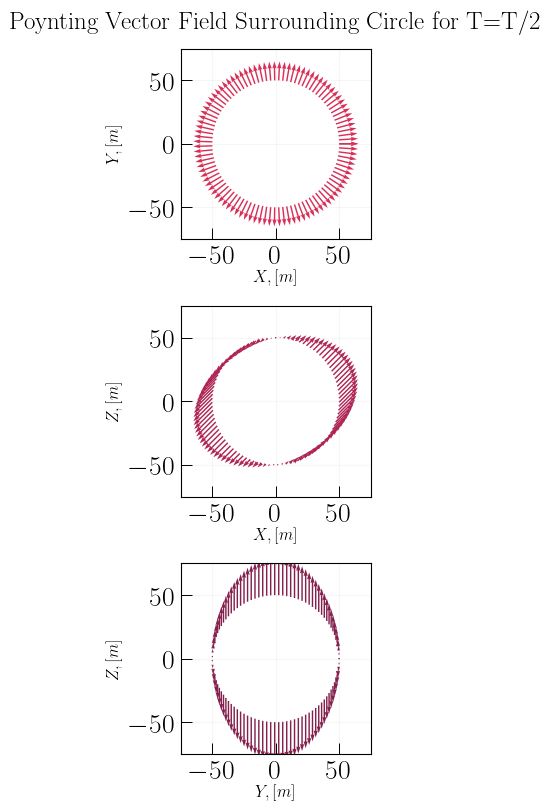

In [367]:
# initiates plotting parameters
width=3;height=8;ff, (ax1,ax2,ax3) = plt.subplots(3,1);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=1.0)

# labels
ax1.set_title(r"Poynting Vector Field Surrounding Circle for T=T/2", pad = 15, fontsize=18)
ax1.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax1.set_ylabel(r"$Y, [m]$",labelpad =5,fontsize=12)
ax2.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax2.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
ax3.set_xlabel(r"$Y, [m]$",labelpad =0, fontsize=12)
ax3.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
# actual plots:

for i in range(len(x_xz)):
    ax1.quiver(x_xy[i], y_xy[i], s_xy_2[i][0],s_xy_2[i][1], color='#d82f57', scale=10)

for i in range(len(x_xz)):
    ax2.quiver(x_xz[i], z_xz[i], s_xz_2[i][0],s_xz_2[i][0], color='#ae2555', scale=10)

for i in range(len(x_xz)):
    ax3.quiver(y_yz[i], z_yz[i], s_yz_2[i][2],s_yz_2[i][1], color='#84204d',scale=5)

ax1.grid(True, alpha=0.1, zorder=10)
ax2.grid(True, alpha=0.1, zorder=10)
ax3.grid(True, alpha=0.1, zorder=10)
ax1.set_xlim(-75, 75)
ax1.set_ylim(-75, 75)
ax2.set_xlim(-75, 75)
ax2.set_ylim(-75, 75)
ax3.set_xlim(-75, 75)
ax3.set_ylim(-75, 75)

plt.show()
    

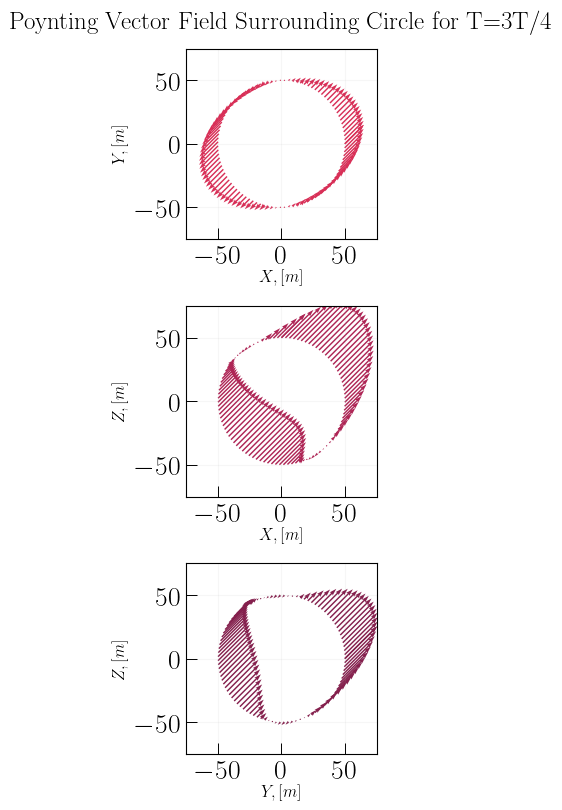

In [353]:
# initiates plotting parameters
width=3;height=8;ff, (ax1,ax2,ax3) = plt.subplots(3,1);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=1.0)

# labels
ax1.set_title(r"Poynting Vector Field Surrounding Circle for T=3T/4", pad = 15, fontsize=18)
ax1.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax1.set_ylabel(r"$Y, [m]$",labelpad =5,fontsize=12)
ax2.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax2.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
ax3.set_xlabel(r"$Y, [m]$",labelpad =0, fontsize=12)
ax3.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
# actual plots:

for i in range(len(x_xz)):
    ax1.quiver(x_xy[i], y_xy[i], s_xy_3[i][0],s_xy_3[i][0], color='#d82f57', scale=10)

for i in range(len(x_xz)):
    ax2.quiver(x_xz[i], z_xz[i], s_xz_3[i][1],s_xz_3[i][1], color='#ae2555', scale=0.01)

for i in range(len(x_xz)):
    ax3.quiver(y_yz[i], z_yz[i], s_yz_3[i][2],s_yz_3[i][2], color='#84204d', scale=0.01)

ax1.grid(True, alpha=0.1, zorder=10)
ax2.grid(True, alpha=0.1, zorder=10)
ax3.grid(True, alpha=0.1, zorder=10)
ax1.set_xlim(-75, 75)
ax1.set_ylim(-75, 75)
ax2.set_xlim(-75, 75)
ax2.set_ylim(-75, 75)
ax3.set_xlim(-75, 75)
ax3.set_ylim(-75, 75)

plt.show()
    

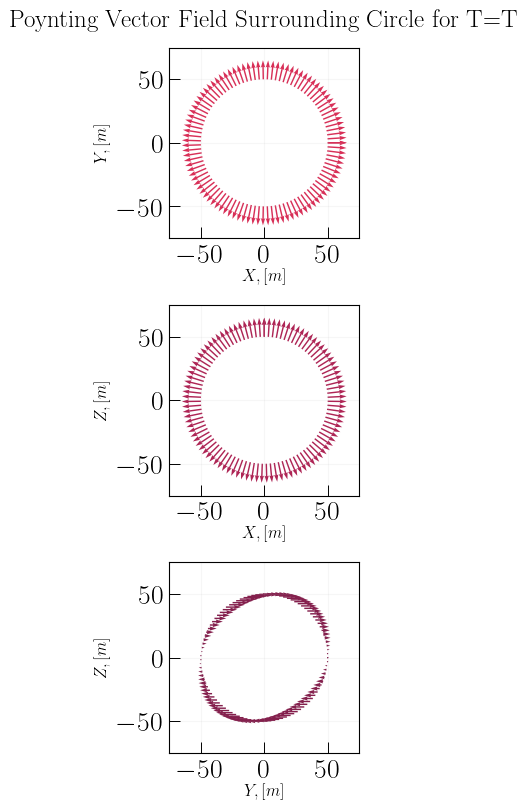

In [343]:
# initiates plotting parameters
width=3;height=8;ff, (ax1,ax2,ax3) = plt.subplots(3,1);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=1.0)

# labels
ax1.set_title(r"Poynting Vector Field Surrounding Circle for T=T", pad = 15, fontsize=18)
ax1.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax1.set_ylabel(r"$Y, [m]$",labelpad =5,fontsize=12)
ax2.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax2.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
ax3.set_xlabel(r"$Y, [m]$",labelpad =0, fontsize=12)
ax3.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
# actual plots:

for i in range(len(x_xz)):
    ax1.quiver(x_xy[i], y_xy[i], s_xy_4[i][0],s_xy_4[i][1], color='#d82f57', scale=10)

for i in range(len(x_xz)):
    ax2.quiver(x_xz[i], z_xz[i], s_xz_4[i][0],s_xz_4[i][2], color='#ae2555', scale=10)

for i in range(len(x_xz)):
    ax3.quiver(y_yz[i], z_yz[i], s_yz_4[i][1],s_yz_4[i][2], color='#84204d', scale=10)

ax1.grid(True, alpha=0.1, zorder=10)
ax2.grid(True, alpha=0.1, zorder=10)
ax3.grid(True, alpha=0.1, zorder=10)
ax1.set_xlim(-75, 75)
ax1.set_ylim(-75, 75)
ax2.set_xlim(-75, 75)
ax2.set_ylim(-75, 75)
ax3.set_xlim(-75, 75)
ax3.set_ylim(-75, 75)

plt.show()
    

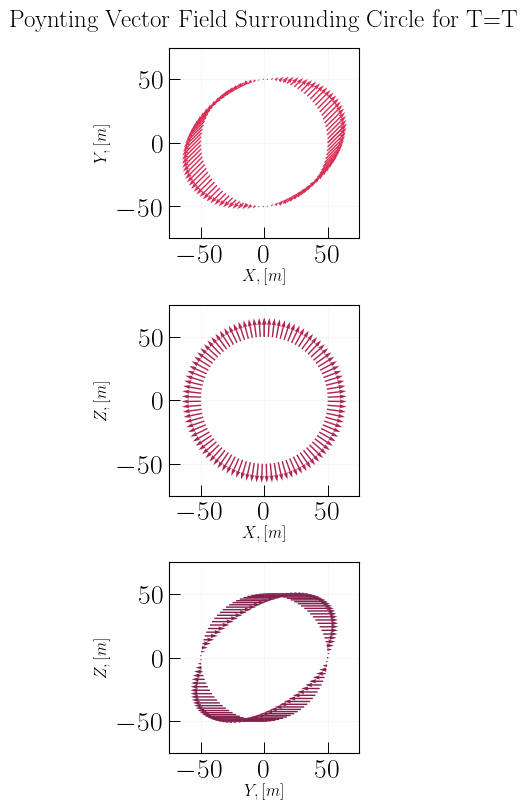

In [384]:
# we can compute a naive time average of these quantities as follows:

s_xy_avg = np.array(s_xy_0+s_xy_1+s_xy_2+s_xy_3+s_xy_4)/5
s_xz_avg = np.array(s_xz_0+s_xz_1+s_xz_2+s_xz_3+s_xz_4)/5
s_yz_avg = np.array(s_yz_0+s_yz_1+s_yz_2+s_yz_3+s_yz_4)/5

# initiates plotting parameters
width=3;height=8;ff, (ax1,ax2,ax3) = plt.subplots(3,1);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=1.0)

# labels
ax1.set_title(r"Time Averaged Poynting Vector", pad = 15, fontsize=18)
ax1.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax1.set_ylabel(r"$Y, [m]$",labelpad =5,fontsize=12)
ax2.set_xlabel(r"$X, [m]$",labelpad =0, fontsize=12)
ax2.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
ax3.set_xlabel(r"$Y, [m]$",labelpad =0, fontsize=12)
ax3.set_ylabel(r"$Z, [m]$",labelpad =5,fontsize=12)
# actual plots:

for i in range(len(x_xz)):
    ax1.quiver(x_xy[i], y_xy[i], s_xy_avg[i][0],s_xy_avg[i][0], color='#d82f57', scale=2)

for i in range(len(x_xz)):
    ax2.quiver(x_xz[i], z_xz[i], s_xz_avg[i][0],s_xz_avg[i][2], color='#ae2555', scale=2)

for i in range(len(x_xz)):
    ax3.quiver(y_yz[i], z_yz[i], s_yz_avg[i][1],s_yz_avg[i][2], color='#84204d', scale=1)

ax1.grid(True, alpha=0.1, zorder=10)
ax2.grid(True, alpha=0.1, zorder=10)
ax3.grid(True, alpha=0.1, zorder=10)
ax1.set_xlim(-75, 75)
ax1.set_ylim(-75, 75)
ax2.set_xlim(-75, 75)
ax2.set_ylim(-75, 75)
ax3.set_xlim(-75, 75)
ax3.set_ylim(-75, 75)

plt.show()
    